# Hands-on 07: Autoencoders for anomaly detection

This week, we will look at autoencoders for anomaly detection. 
First we will install the `jetnet` library and restart the kernel.

The goal is to train an autoencoder to reconstruct QCD (background) jets, which are plentiful at the LHC.
Then we will apply it to top quark (signal) jets to see if the reconstruction error is larger.
The reconstruction error can then be used as an *anomaly score* in real data.

This autoencoder architecture used is inspired by this paper: https://arxiv.org/abs/1808.08992.
![Autoencoder](https://inspirehep.net/files/70ddba8443dc13268cf2f0521c302338)

In [1]:
! pip install --user --quiet jetnet


[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Download the dataset

We will use a validation dataset of 400k jets, which is plenty for our purposes.
The full dataset is available at https://doi.org/10.5281/zenodo.2603255.

In [2]:
import jetnet

im_size = 16
jet_r = 0.8
max_jets = 50000

# download the validation data (400k jets, which is plenty for our purposes)
# full dataset is available here: https://doi.org/10.5281/zenodo.2603255
data = jetnet.datasets.TopTagging(
    jet_type="all",
    particle_features=["E", "px", "py", "pz"],
    jet_features=["type"],
    split="valid",
    data_dir="data/",
    particle_transform=jetnet.utils.cartesian_to_relEtaPhiPt,
)

## Transform and split the data

The data is originally up to 200 particles per jet (zero-padded), and the features are the standard 4-vectors $(E, p_x, p_y, p_z)$. 
We can assume the particles are massless so $E=\sqrt{p_x^2+p_y^2+p_z^2}$ and there are only 3 degrees of freedom.

We will transform to relative coordinates centered on the jet using the function [`jetnet.utils.cartesian_to_relEtaPhiPt`](https://jetnet.readthedocs.io/en/latest/pages/utils.html#jetnet.utils.cartesian_to_relEtaPhiPt):
\begin{align}
\eta^\mathrm{rel} &=\eta^\mathrm{particle} - \eta^\mathrm{jet}\\
\phi^\mathrm{rel} &=\phi^\mathrm{particle} - \phi^\mathrm{jet} \pmod{2\pi}\\
p_\mathrm{T}^\mathrm{rel} &= p_\mathrm{T}^\mathrm{particle}/p_\mathrm{T}^\mathrm{jet}
\end{align}

In [3]:
import numpy as np

indices = np.random.permutation(np.arange(len(data)))[:max_jets]

In [4]:
# transform the data
transformed_particle_data = data.particle_transform(data.particle_data[indices])

In [5]:
# split qcd background and top quark signal
qcd_data = transformed_particle_data[data.jet_data[indices][:, 0] == 0]
top_data = transformed_particle_data[data.jet_data[indices][:, 0] == 1]

In [6]:
from sklearn.model_selection import train_test_split

qcd_train, qcd_test = train_test_split(qcd_data, test_size=0.2, random_state=42)
top_train, top_test = train_test_split(top_data, test_size=0.2, random_state=42)

## Convert data to jet images

In [7]:
import numpy as np

#  convert full dataset
qcd_train_images = np.expand_dims(jetnet.utils.to_image(qcd_train, im_size=im_size, maxR=jet_r), axis=-1)
qcd_test_images = np.expand_dims(jetnet.utils.to_image(qcd_test, im_size=im_size, maxR=jet_r), axis=-1)
top_test_images = np.expand_dims(jetnet.utils.to_image(top_test, im_size=im_size, maxR=jet_r), axis=-1)

# rescale so sum is 1 (it should be close already)
qcd_train_images = qcd_train_images / np.sum(qcd_train_images.reshape(-1, 1, 1, 1, im_size * im_size), axis=-1)
qcd_test_images = qcd_test_images / np.sum(qcd_test_images.reshape(-1, 1, 1, 1, im_size * im_size), axis=-1)
top_test_images = top_test_images / np.sum(top_test_images.reshape(-1, 1, 1, 1, im_size * im_size), axis=-1)

## Visualize the jet images

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


def plot_jet_images(images, titles, filename="jet_image.pdf"):

    n_images = len(images)
    plt.figure(figsize=(5 * n_images, 5))

    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, n_images, i + 1)
        plt.title(title)
        plt.imshow(image, origin="lower", norm=LogNorm(vmin=1e-3, vmax=1))
        cbar = plt.colorbar()
        plt.xlabel(r"$\Delta\eta$ cell", fontsize=15)
        plt.ylabel(r"$\Delta\phi$ cell", fontsize=15)
        cbar.set_label(r"$p_T/p_T^{jet}$", fontsize=15)

    plt.tight_layout()
    plt.savefig(filename)

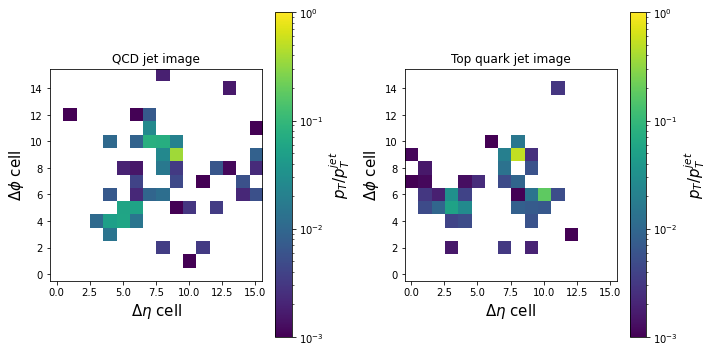

In [9]:
plot_jet_images([qcd_test_images[0], top_test_images[0]], ["QCD jet image", "Top quark jet image"])

## Define the autoencoder model

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense,
    Input,
    Conv2D,
    Conv2DTranspose,
    Reshape,
    Flatten,
    Softmax,
)

x_in = Input(shape=(im_size, im_size, 1))
x = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="same")(x_in)
x = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="same")(x)
x = Flatten()(x)

x_enc = Dense(2, name="bottleneck")(x)

x = Dense(int(im_size * im_size / 16) * 128, activation="relu")(x_enc)
x = Reshape((int(im_size / 4), int(im_size / 4), 128))(x)
x = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="same")(x)
x = Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), activation="linear", padding="same")(x)
x_out = Softmax(name="softmax", axis=[-2, -3])(x)
model = Model(inputs=x_in, outputs=x_out, name="autoencoder")

model.compile(loss="mse", optimizer="adam")
model.summary()

# save the encoder-only model for easy access to latent space
encoder = Model(inputs=x_in, outputs=x_enc, name="encoder")

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 128)         1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 bottleneck (Dense)          (None, 2)                 4098      
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         

2023-03-05 22:50:48.657977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train the autoencoder model

In [11]:
history = model.fit(
    qcd_train_images,
    qcd_train_images,
    batch_size=32,
    epochs=10,
    verbose=0,
    validation_data=(qcd_test_images, qcd_test_images),
)

## Reconstruction performance

1/1 [==============================] - 0s 145ms/step


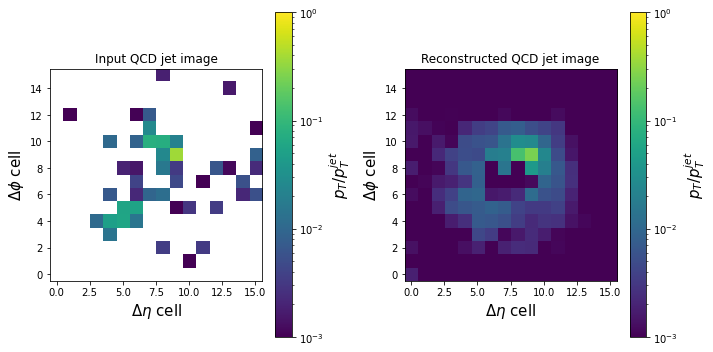

In [12]:
qcd_reco_image = model.predict(qcd_test_images[0:1]).reshape(im_size, im_size)
plot_jet_images([qcd_test_images[0], qcd_reco_image], ["Input QCD jet image", "Reconstructed QCD jet image"])

1/1 [==============================] - 0s 21ms/step


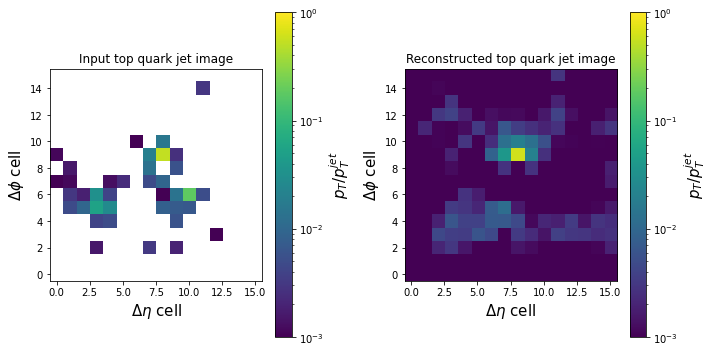

In [14]:
top_reco_image = model.predict(top_test_images[0:1]).reshape(im_size, im_size)
plot_jet_images([top_test_images[0], top_reco_image], ["Input top quark jet image", "Reconstructed top quark jet image"])

## Anomaly detection performance

In [15]:
qcd_reco_images = model.predict(qcd_test_images)
top_reco_images = model.predict(top_test_images)

156/156 [==============================] - 1s 4ms/step


In [16]:
diff_qcd = np.power((qcd_reco_images - qcd_test_images), 2)
loss_qcd = np.mean(diff_qcd.reshape(-1, im_size * im_size), axis=-1)

diff_top = np.power((top_reco_images - top_test_images), 2)
loss_top = np.mean(diff_top.reshape(-1, im_size * im_size), axis=-1)

loss_all = np.concatenate([loss_qcd, loss_top])

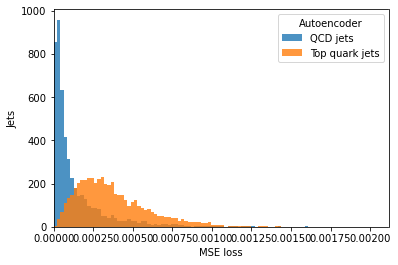

In [17]:
plt.figure()
bins = np.arange(0, np.max(loss_all), np.max(loss_all) / 100)
plt.hist(loss_qcd, label="QCD jets", bins=bins, alpha=0.8)
plt.hist(loss_top, label="Top quark jets", bins=bins, alpha=0.8)
plt.legend(title="Autoencoder")
plt.xlabel("MSE loss")
plt.ylabel("Jets")
plt.xlim(0, np.max(loss_all))
plt.savefig("/Users/cpare/Downloads/MSE_Loss_distribution.png")
plt.show()

## Exercises
1. Plot the ROC curve for the MSE loss of the autoencoder on the merged testing sample of QCD and top quark jets, assuming a label of 1 for top quark jets and a label of 0 for QCD jets. Report the AUC.
2. Perform a PCA on only the QCD training images using `sklearn.decomposition.PCA` with 2 components. Note you will have to reshape the image tensors so that they are 2D instead of 4D (as required by the autoencoder), e.g. `qcd_test_images.reshape(-1, im_size * im_size))`. Plot the distribution of the reconstruction losses for top quark jets and QCD jets separately. Hint: review https://rittikghosh.com/autoencoder.html.
3. Plot the PCA ROC curve similar to part 1. Report the AUC.
6. Plot the 2D latent space for the QCD and top quark test images for both the autoencoder and the PCA.

## Homework 4 Problem A

In [18]:
from sklearn.metrics import roc_curve, auc
import numpy as np


In [19]:
loss_qcd_top = np.concatenate([loss_qcd, loss_top])
labels_qcd_top = np.concatenate([np.zeros(len(loss_qcd)), np.ones(len(loss_top))])


<Figure size 432x288 with 0 Axes>

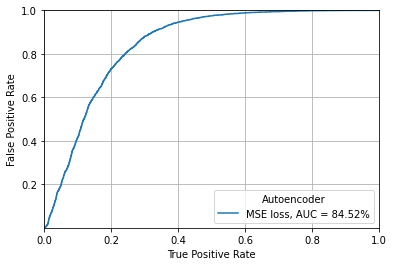

<Figure size 432x288 with 0 Axes>

In [20]:
false_positve_rate, true_positve_rate, thresholds = roc_curve(labels_qcd_top,loss_qcd_top)

plt.plot(false_positve_rate, true_positve_rate, label = f"MSE loss, AUC = {auc(false_positve_rate, true_positve_rate)*100:.2f}%")
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.grid()
plt.xlim(0,1)
plt.ylim(1e-3, 1)
plt.legend(title = "Autoencoder")
plt.savefig("/Users/cpare/Downloads/roc_hw4.png")
plt.figure()

## Homework4 Problem B

In [23]:
from sklearn.decomposition import PCA

In [38]:
pca = PCA(n_components=2)

pca.fit(qcd_train_images.reshape(-1, im_size * im_size))

pca_qcd_jets = pca.transform(qcd_test_images.reshape(-1, im_size * im_size))
pca_top_jets = pca.transform(top_test_images.reshape(-1, im_size * im_size))

pca_all_jets = np.concatenate([pca_qcd, pca_top], axis=0)

In [39]:
pca_all = np.concatenate([pca_qcd_jets, pca_top_jets], axis = 0)

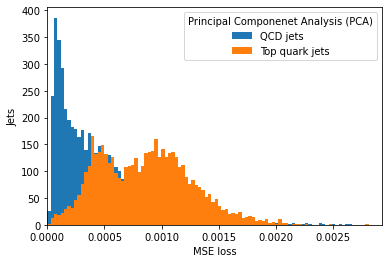

In [45]:
pca_qcd_inverse = pca.inverse_transform(pca_qcd_jets)
top_qcd_inverse = pca.inverse_transform(pca_top_jets)

diff_qcd_pca = np.power(qcd_test_images.reshape(-1, im_size * im_size) - pca_qcd_inverse, 2)
loss_qcd_pca = diff_qcd_pca.mean(axis=-1)

diff_top_pca = np.power(top_test_images.reshape(-1, im_size * im_size) - top_qcd_inverse, 2)
loss_top_pca = diff_top_pca.mean(axis=-1)

loss_all_pca = np.concatenate([loss_qcd_pca, loss_top_pca])

plt.figure()
bins = np.arange(0, np.max(loss_all_pca), np.max(loss_all_pca) / 100)
plt.hist(loss_qcd_pca, label="QCD jets", bins=bins)
plt.hist(loss_top_pca, label="Top quark jets", bins=bins)
plt.legend(title="Principal Componenet Analysis (PCA)")
plt.xlabel("MSE loss")
plt.ylabel("Jets")
plt.xlim(0, np.max(loss_all_pca))
plt.savefig("/Users/cpare/Downloads/MSE_PCA.png")
plt.show()

## Homework4 Problem C

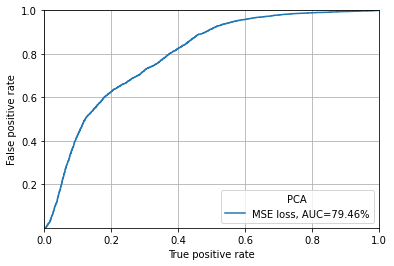

In [46]:
fpr, tpr, thresholds = roc_curve(labels_qcd_top, loss_all_pca)

plt.figure()
plt.plot(fpr, tpr, label=f"MSE loss, AUC={auc(fpr_pca, tpr_pca)*100:.2f}%")
plt.legend(title="PCA")
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.grid()
plt.xlim(0, 1)
plt.ylim(1e-3, 1)
plt.savefig("/Users/cpare/Downloads/ROC_curve_PCA.png")
plt.show()

## Homework4 Problem D

In [50]:
qcd_encoder = encoder.predict(qcd_test_images)
top_encoder = encoder.predict(top_test_images)

156/156 [==============================] - 0s 3ms/step


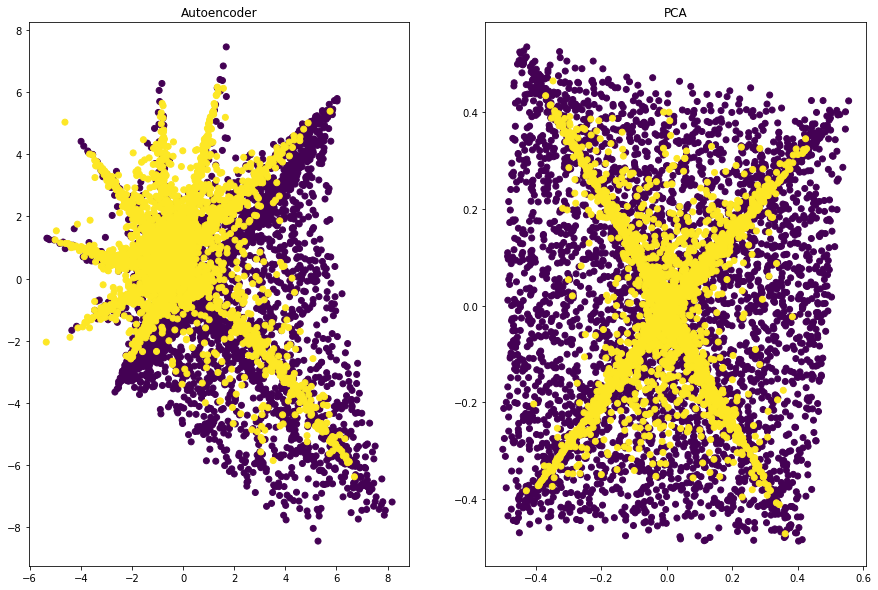

In [62]:
encoder_all = np.concatenate([qcd_encoder, top_encoder], axis=0)
fig, ax = plt.subplots(1, 2, figsize=(15, 10))


ax[0].scatter(encoder_all[:,0], encoder_all[:,1], c= labels_qcd_top)
ax[0].set_title("Autoencoder")
ax[1].scatter(pca_all[:,0], pca_all[:,1], c = labels_qcd_top)
ax[1].set_title("PCA")



plt.savefig("/Users/cpare/Downloads/QCD_top_quark_jets_images.png")